In [1]:
# Задание:  
# Retention – один из самых важных показателей в компании. 
# Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [2]:
import pandas as pd
import numpy as np

# Matplotlib forms basis for visualization in Python
import matplotlib.pyplot as plt

# We will use the Seaborn library
import seaborn as sns
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
        )

In [3]:
# Функция расчета retention игроков (по дням от даты регистрации игрока)
#
# Входные параметры:
#    reg_data - данные о времени регистрации,
#               должен иметь поля uid - uid пользователя, reg_ts_date - дата регистрации  
#    auth_data - данные о времени захода пользователей в игру, 
#               должен иметь поля uid - uid пользователя, auth_ts_date - дата захода в игру  
#
# Результат:
#    Таблица retention игроков (по дням от даты регистрации игрока)
#
def get_retention(
    reg_data, # данные о времени регистрации
    auth_data # данные о времени захода пользователей в игру
):
    # Результат работы функции
    df = pd.DataFrame(columns=['date', 'day', 'retention'])
       
    # Посчитаем количество зарегистрировавшихся пользователей по дням
    reg_data_resample = reg_data.resample('1d').uid.count()
        
    # Удаляем даты, где не было регистраций    
    reg_data_resample = reg_data_resample.where(reg_data_resample!=0).dropna()
    
    # Полученную таблицу reg_data_resample можно использовать для расчета retention по дням регистрации пользователей
    for reg_date in reg_data_resample.index:           
        # Обнуляем retention
        retention = 0
        
        # Количество пользователей, которые зарегистрировались в день reg_date
        reg_uids_count = reg_data_resample[reg_date]
        
        # Получим список уникальных пользователей, которые зарегистрировались в день reg_date
        reg_uids = reg_data.loc[reg_date:reg_date + pd.DateOffset(1)].uid.unique()
        
        # Удалим из таблицы auth_data всех пользователей, которые не были зарегистрированы в день reg_date
        auth_data_uid = auth_data.query('uid in @reg_uids')
        
        # Посчитаем количество заходивших в приложение пользователей, которые были зарегистрированы в день reg_date, по дням
        auth_data_uid_resample = auth_data_uid.resample('1d').uid.count()
        
        # Добавим данные по retention дня регистрации в результирующую таблицу (retention = 100%)
        df = df.append({"date": reg_date, "day": 0, "retention": 100.0}, ignore_index=True )
      
        # Пройдемся по всем дня захода пользователей в приложение и посчитаем retention каждого дня
        auth_day = reg_date + pd.DateOffset(1)
        day = 1     
        while auth_day <= auth_data_uid_resample.index.max():
            
            # Если пользователь не заходил в день auth_day в приложение,  
            # то в таблице auth_data_uid_resample этой даты не будет, 
            # и при обращении к таблице по этой дате возникнет ошибка, в этом случае retention считаем равным 0 
            try:
                # retention = 100 * (Количество_пользователей_в_приложении_на_дату/Количество_пользователей_на_день_регистрации)
                retention = 100 * (auth_data_uid_resample[auth_day]/reg_uids_count)
            except:
                retention = 0
                print('except')
        
            # Заносим полученные данные в результирующую таблицу
            df = df.append({"date": reg_date, "day": day, "retention": retention}, ignore_index=True )
                
            # Сдвигаем дату на следующий день
            auth_day = auth_day + pd.DateOffset(1)
            day = day + 1
            
    return df

In [54]:
# 
# Количество прочитанных строк файла данных (размер сэмпла прочитанных данных)
nrows_reg = 50 # для файла с данными о регистрации пользователей
nrows_auth = 200 # для файла с данными о входе пользователей в приложение 

In [55]:
# Читаем данные о регистрации пользователей
reg_data = pd.read_csv('/home/jupyter-a.korobkova-11/shared/problem1-reg_data.csv', sep = ';', nrows = nrows_reg)

In [56]:
# Размер данных
reg_data.shape

(50, 2)

In [57]:
# Проверим типы колонок прочитанных данных
reg_data.dtypes

reg_ts    int64
uid       int64
dtype: object

In [58]:
# Посмотрим данные
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [59]:
# Читаем данные о входе пользователей в приложение 
auth_data = pd.read_csv('/home/jupyter-a.korobkova-11/shared/problem1-auth_data.csv', sep = ';', nrows = nrows_auth)

In [60]:
# Размер данных
auth_data.shape

(200, 2)

In [61]:
# Проверим типы колонок прочитанных данных
auth_data.dtypes

auth_ts    int64
uid        int64
dtype: object

In [62]:
# Посмотрим данные
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [63]:
# Переводим время в формат даты
auth_data['auth_ts_date'] = pd.to_datetime(auth_data.auth_ts, unit='s')
reg_data['reg_ts_date'] = pd.to_datetime(reg_data.reg_ts, unit='s')

In [64]:
# Подготовим таблицы для сэмплирования (установим дату как индекс)
reg_data.set_index('reg_ts_date', inplace = True)
auth_data.set_index('auth_ts_date', inplace = True)

In [65]:
# Посчитаем retention игроков (по дням от даты регистрации игрока) 
retention_table = get_retention(reg_data, auth_data)

In [66]:
# Переведем дату в строку (для дальнего вывода)
retention_table['date'] = pd.to_datetime(retention_table["date"]).dt.strftime("%Y-%m-%d")

In [67]:
# Сформируем сводную таблицу
retention_table_pivot = retention_table.pivot(index='date', columns = 'day', values = 'retention').fillna(0)

In [68]:
retention_table_pivot.head(20)

day,0,1,2,3,4,5,6,7,8,9,...,781,782,783,784,785,786,787,788,789,790
date,,,,,,,,,,,,,,,,,,,,,
1998-11-18,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999-07-22,100.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0,...,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2000-01-13,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-05-28,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-09-16,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-12-19,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-03-10,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-05-21,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-07-24,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


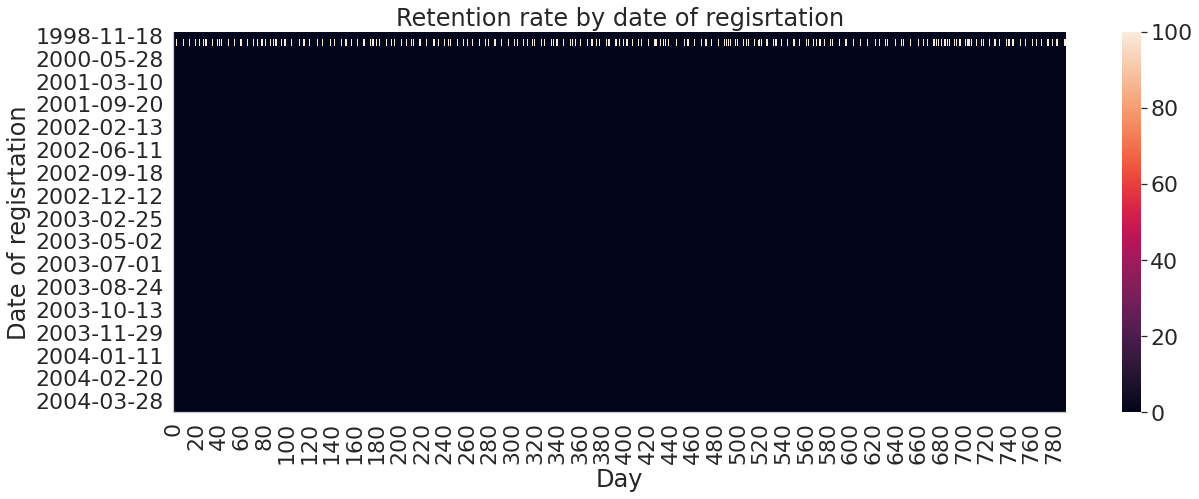

In [69]:
# Нарисуем полученные данные 
ax = sns.heatmap(retention_table_pivot, fmt=".0f", annot_kws={"size": 10})

plt.xlabel('Day')
plt.ylabel('Date of regisrtation')
plt.title('Retention rate by date of regisrtation')

sns.despine()